In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK50_1"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}.txt".format(dataset))

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context,to_csv=True,filename=dataset)
station_coordinates = pd.read_csv('../datasets/{}_coordinates.csv'.format(dataset), encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()

# #UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000
# #distance_matrix_here,time_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/",dataset)

distance_matrix_here = distance_matrix_here.to_numpy()
time_matrix_here = time_matrix_here.to_numpy()

routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
startNodes = {"UK20_1":[0,6,10,15],"UK50_1":[0,6,10,15,21,35,40],"UK75_1":[0,6,10,15,21,35,40,60,31,68]}
endNodes = {"UK20_1":[4,20,2,5],"UK50_1":[4,20,2,5,32,45,1],"UK75_1":[0,6,10,15,21,35,40,60,31,68]}



In [3]:
def create_initial_solution(nodes,vehicles,end_positions,transit_cost_function,cost_function_parameter_dict:dict):
    result = []

    ends = deepcopy(end_positions)
    pickup_points=deepcopy(nodes)
    
    for index,vehicle in enumerate(vehicles):
        result.append(vehicle)
        node_amount = int(len(pickup_points)/len(vehicles))
        closest_positions = sorted(pickup_points, key = lambda node: transit_cost_function(vehicles[vehicle]["startPos"],node,**cost_function_parameter_dict))[:node_amount]

        for taken_position in closest_positions:
            pickup_points.remove(taken_position)
            result.append(taken_position)
        
        if len(ends) > 1:
            closest_end = sorted(ends, key = lambda node: transit_cost_function(result[-1],node,**cost_function_parameter_dict))[0]
        elif len(ends) == 1:
            closest_end = ends[0]
        
        result.append(100+index)
        ends.remove(closest_end)
        
        
        
    for node in pickup_points:
        if node not in result:
            result.insert(1,node)

    return result



In [4]:
startNodeIndeces = startNodes[dataset]
endNodeIndeces = endNodes[dataset]
locationNodeIndeces = list((set(range(len(points_coordinate))) - set(startNodeIndeces)) - set(endNodeIndeces))

vehicleData = {"emptyWeights":[3000],"maxLoads":[3650],"fuelEmpty":[12],"fuelFull":[15]}
vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,
                                                            routingContext=routingContext)

customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[startNodeIndeces+endNodeIndeces] = 0
station_data["Demand(kg)"] = customer_demands
#station_data.iloc[startNodeIndeces+endNodeIndeces,"Demand(kg)"] = 0

translate_dict = {}
for i,x in enumerate(endNodeIndeces):
    translate_dict[x] = 100+i
initial_solution = cheapest_insertion_dict(locationNodeIndeces,vehicles,endNodeIndeces,routingContext)



cost_function_dict = {"distance_matrix":distance_matrix_here,"time_matrix":time_matrix_here,
                              "demands":customer_demands,"vehicle_weight":3000,"start_positions":startNodeIndeces,"meta_data":meta_data}

old_init_sol = create_initial_solution(locationNodeIndeces,vehicles,endNodeIndeces,fuel_consumption_wong,cost_function_dict)

#initial_solution_no_starts =initial_solution_kmeans(locationNodeIndeces,endNodeIndeces,points_coordinate,translate_dict)# 
data_model_input_multi_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution["flattened"],
                                    'objective_amount':2,'objective_labels':['Total Fuel','Total Drive Time'],
                                    'constraint_amount':5,'number_of_cities':routingContext.distance_matrix.shape[0]}

data_model_input_single_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution["flattened"],
                                    'objective_amount':1,'objective_labels':['Total Fuel'],
                                    'constraint_amount':5,'number_of_cities':routingContext.distance_matrix.shape[0]}

problem = VRP(data_model_input_multi_objective)

plot_data_storage_base = {'fitness':[],'fuel_consumption':[],'computation_times':[],'maxDriveTimes':[],'violation':[],'paths':[],'IGD':[]}


amount_of_runs = 10
amount_of_evaluations = 3000


In [5]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

computation_times = []
parameter_list_NSGAIII = [{"mutation":0.6,"crossover":0.2}]#,{"mutation":0.6,"crossover":0.5},{"mutation":0.6,"crossover":0.8}]

parameter_data_NSGAIII = []
computation_times_NSGAIII = []
results_NSGAIII = []




for index,param in enumerate(parameter_list_NSGAIII):
    plot_data_NSGAIII = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        
        problem_NSGAIII = VRP(data_model_input_multi_objective)
        problem_NSGAIII.name = "NSGA-III"
        problem_NSGAIII.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations
        
        algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                                population_size=10,
                                reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                                mutation= PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations)
                                ,population_evaluator=MultiprocessEvaluator()
                                   )
        performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=1,params=parameter_list_NSGAIII)
        performance_observer_NSGAIII.maxEpochs= len(parameter_list_NSGAIII) * amount_of_runs
        performance_observer_NSGAIII.currentEpoch = (index*amount_of_runs) + x

        algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
        algorithm_NSGAIII.run()
        
        solutions_NSGAIII = algorithm_NSGAIII.get_result()
        front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)
        
        store_plot_data(plot_data_NSGAIII,performance_observer_NSGAIII,front_NSGAIII[0].path)
        
        
    param["paramGroup"] = index
    param["algorithm"] = problem_NSGAIII.name

    parameter_data_NSGAIII.append({"parameters":param,"results":plot_data_NSGAIII})
        
nsga3_numerical_path = get_numerical_path(front_NSGAIII[0].path,vehicles)



#get_results(temp_path,problem_NSGAIII.routing_context.distance_matrix,station_data,meta_data,time_matrix_here)

Epoch:10 of 10
Evaluations: 3000/3000
Params: {'mutation': 0.6, 'crossover': 0.2} 
IGD:1721.6268632131457
Best fitness: 210.1725 --- 1708.75                        
Best total fuel consumption:210.17 
Computing time: 3.3s                        
Average computing speed: 909.9it/s
Current Route:[['V6', 43, 22, 11, 49, 28, 12, 23, 9, 1], ['V1', 48, 31, 46, 27, 44, 7, 8, 2], ['V2', 18, 39, 3, 20], ['V0', 47, 34, 19, 16, 29, 38, 2], ['V4', 17, 36, 25, 13, 14, 50, 26, 2], ['V5', 41, 37, 24, 33, 30, 42, 20]]
Flags: []                        
Violation:0
Vehicle amount:6


In [6]:
plot_data_NSGAIII.keys()

dict_keys(['fitness', 'fuel_consumption', 'computation_times', 'maxDriveTimes', 'violation', 'paths', 'IGD'])

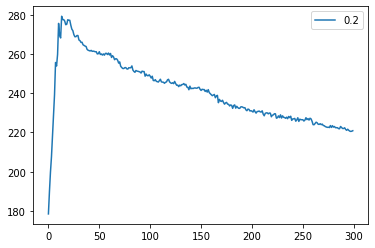

In [7]:
labels = [run["parameters"] for run in parameter_data_NSGAIII]
data = np.array([run["results"]["fuel_consumption"] for run in parameter_data_NSGAIII])

for i in range(len(labels)):

    plt.plot(np.mean(data[i],axis=0),label=labels[i]["crossover"])
plt.legend()
plt.show()

In [8]:
get_results(nsga3_numerical_path,pd.DataFrame(problem_NSGAIII.routing_context.distance_matrix),station_data,meta_data,pd.DataFrame(time_matrix_here))

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Wong et al.),Avg Estimated Fuel Conspumtion (L/100km) (Wong et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,224.708,3589,30.588661,13.612627,25.543550,11.367441,44.226603,18291,05:04:51.00
1,321.557,3139,43.359300,13.484172,38.402717,11.942740,49.847358,23223,06:27:03.00
2,94.883,788,12.085120,12.736865,9.593671,10.111054,39.612525,8623,02:23:43.00
3,172.990,3291,22.949153,13.266173,24.748168,14.306126,36.867393,16892,04:41:32.00
4,208.401,3303,28.675903,13.759964,23.397785,11.227290,53.696221,13972,03:52:52.00
5,326.423,3175,43.097892,13.203081,37.377497,11.450632,54.595930,21524,05:58:44.00


In [9]:
from jmetal.algorithm.singleobjective import SimulatedAnnealing
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation,SimpleRandomMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.comparator import DominanceComparator
from datetime import datetime
parameter_list_SA = [{"mutation":0.9}]#,{"mutation":0.5},]
#for x in np.arange(0.1,1,0.1):
#    parameter_list_SA.append({"mutation":np.round(x,2)})



parameter_data_SA = []
computation_times_SA = []
results_SA = []

for index,param in enumerate(parameter_list_SA):
    plot_data_SA = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        problem_SA = VRP(data_model_input_single_objective)
        problem_SA.name = "SA"
        problem_SA.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations

        algorithm_SA = SimulatedAnnealing(problem=problem_SA,
                                       mutation=PermutationSwapMutation(param["mutation"]),
                                       termination_criterion=StoppingByEvaluations(max_evaluations))
        algorithm_SA.alpha=1
        performance_observer_SA = PerformanceObserver(max_iter=max_evaluations,frequency=10,params=parameter_list_SA)
        performance_observer_SA.maxEpochs= len(parameter_list_SA) * amount_of_runs
        performance_observer_SA.currentEpoch = (index*amount_of_runs) + x

        algorithm_SA.observable.register(observer=performance_observer_SA)
        algorithm_SA.run() 
        
        solutions_SA = algorithm_SA.get_result()        
        store_plot_data(plot_data_SA,performance_observer_SA,solutions_SA.path)
    param["paramGroup"] = index
    param["algorithm"] = problem_SA.name

    parameter_data_SA.append({"parameters":param,"results":plot_data_SA})
sa_numerical_path = get_numerical_path(solutions_SA.path,vehicles)
#saveParameterData(logPath,"SA_data",parameter_data_SA)

Epoch:10 of 10
Evaluations: 3000/3000
Params: {'mutation': 0.9}
IGD:1584.1439998288292
Best fitness: 1770.7912                          
Best total fuel consumption:199.22 
Best total drive time:1571.57                          
Computing time: 2.19s
Average computing speed: 1371.96it/s                          
Current Route:[['V6', 22, 43, 42, 33, 30, 28, 23, 12, 20], ['V1', 46, 8, 27, 38, 44, 7, 48, 4], ['V2', 11, 18, 39, 20], ['V3', 47, 34, 19, 29, 16, 24, 31, 2], ['V4', 25, 13, 14, 50, 26, 37, 2], ['V5', 41, 36, 17, 49, 3, 9, 1]]
Flags: []
Violation:0
Vehicle Amount:6


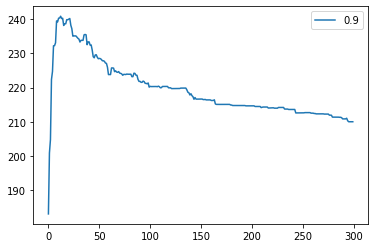

In [10]:
labels = [run["parameters"] for run in parameter_data_SA]
data = np.array([run["results"]["fuel_consumption"] for run in parameter_data_SA])

for i in range(len(labels)):

    plt.plot(np.mean(data[i],axis=0),label=labels[i]["mutation"])
plt.legend()
plt.show()

In [11]:
get_results(sa_numerical_path,pd.DataFrame(problem_SA.routing_context.distance_matrix),station_data,meta_data,pd.DataFrame(time_matrix_here))

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Wong et al.),Avg Estimated Fuel Conspumtion (L/100km) (Wong et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,188.255,3649,25.955856,13.787605,20.331146,10.799791,42.405081,15982,04:26:22.00
1,322.167,3546,45.592683,14.151879,36.028424,11.183152,54.027167,21467,05:57:47.00
2,97.631,996,12.683483,12.991245,9.643081,9.877069,40.310999,8719,02:25:19.00
3,144.370,3378,19.684323,13.634635,15.767233,10.921405,33.294811,15610,04:20:10.00
4,183.496,2980,24.999454,13.623978,20.093017,10.950111,52.431590,12599,03:29:59.00
5,306.765,2736,40.462490,13.190061,33.401546,10.888317,55.447808,19917,05:31:57.00


In [12]:
from jmetal.algorithm.multiobjective.ibea import IBEA
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameter_list_IBEA =[{"mutation":0.9,"crossover":0.65}]

generation_amount = 0
parameter_data_IBEA = []
computation_times_IBEA = []
results_IBEA = []
fronts = []
for index,param in enumerate(parameter_list_IBEA):
    plot_data_IBEA = deepcopy(plot_data_storage_base)
    for x in range(amount_of_runs):
        problem_IBEA = VRP(data_model_input_multi_objective)
        problem_IBEA.name = "IBEA"
        problem_IBEA.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations

        algorithm_IBEA = IBEA(problem=problem_IBEA,
                                population_size=10,
                                offspring_population_size=10,
                                kappa =1,
                                mutation=PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations),
                                population_evaluator=MultiprocessEvaluator(),
                                   )
        
        performance_observer_IBEA = PerformanceObserver(max_iter=max_evaluations,frequency=10,params=parameter_list_IBEA)
        performance_observer_IBEA.maxEpochs= len(parameter_list_IBEA) * amount_of_runs
        performance_observer_IBEA.currentEpoch = (index*amount_of_runs) + x
         
        
        algorithm_IBEA.observable.register(observer=performance_observer_IBEA)
        algorithm_IBEA.run()
        
        solutions_IBEA = algorithm_IBEA.get_result()
        front_IBEA = get_non_dominated_solutions(solutions_IBEA)
        store_plot_data(plot_data_IBEA,performance_observer_IBEA,front_IBEA[0].path)
        
ibea_numerical_path = get_numerical_path(front_IBEA[0].path,vehicles)

Epoch:10 of 10
Evaluations: 3000/3000
Params: {'mutation': 0.9, 'crossover': 0.65} 
IGD:1581.9756929104476
Best fitness: 198.6522 --- 1577.8333                        
Best total fuel consumption:198.65 
Computing time: 3.93s                        
Average computing speed: 762.92it/s
Current Route:[['V0', 43, 22, 42, 30, 33, 28, 23, 12, 20], ['V1', 46, 8, 24, 27, 44, 7, 48, 4], ['V2', 11, 18, 39, 20], ['V3', 47, 34, 19, 16, 29, 38, 31, 2], ['V4', 41, 36, 25, 13, 14, 50, 26, 37, 2], ['V5', 17, 45], ['V6', 49, 3, 9, 1]]
Flags: []                        
Violation:0
Vehicle amount:7


In [13]:
get_results(ibea_numerical_path,pd.DataFrame(problem_IBEA.routing_context.distance_matrix),station_data,meta_data,pd.DataFrame(time_matrix_here))

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Wong et al.),Avg Estimated Fuel Conspumtion (L/100km) (Wong et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,194.774,3649,26.749565,13.733643,22.407082,11.504145,42.891265,16348,04:32:28.00
1,316.989,3274,44.428713,14.015853,35.626929,11.239169,53.500253,21330,05:55:30.00
2,97.631,996,12.683483,12.991245,9.643081,9.877069,40.310999,8719,02:25:19.00
3,138.702,3650,18.980750,13.684554,15.936843,11.489988,32.354513,15433,04:17:13.00
4,327.020,3541,43.791248,13.391000,35.939224,10.989916,56.564263,20813,05:46:53.00
5,71.030,701,9.015896,12.693082,7.635241,10.749318,52.539141,4867,01:21:07.00
6,95.566,1474,12.496936,13.076760,10.407318,10.890188,48.049944,7160,01:59:20.00


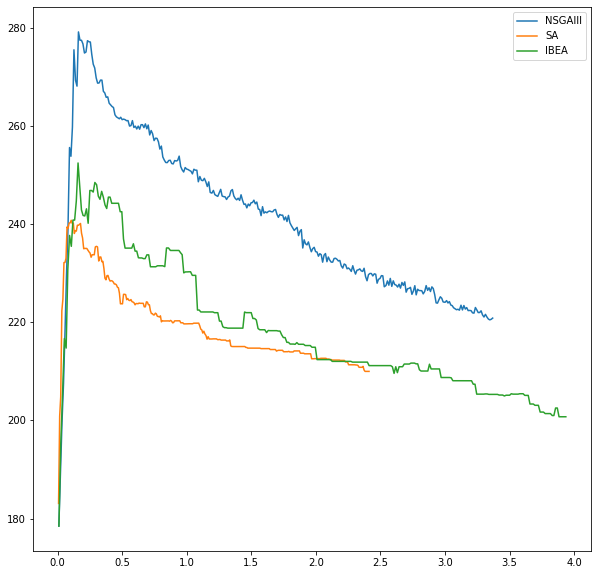

In [14]:
plt.figure(figsize=(10,10))


plt.plot(np.mean(plot_data_NSGAIII["computation_times"],axis=0),np.mean(plot_data_NSGAIII["fuel_consumption"],axis=0),label="NSGAIII")
plt.plot(np.mean(plot_data_SA["computation_times"],axis=0),np.mean(plot_data_SA["fuel_consumption"],axis=0),label="SA")
plt.plot(np.mean(plot_data_IBEA["computation_times"],axis=0),np.mean(plot_data_IBEA["fuel_consumption"],axis=0),label="IBEA")

plt.legend()
plt.show()

In [42]:



    

    
    
nsgaiii_curve = np.mean(plot_data_NSGAIII["fuel_consumption"], axis=0)
sa_curve = np.mean(plot_data_SA["fuel_consumption"], axis=0)
ibea_curve = np.mean(plot_data_IBEA["fuel_consumption"], axis=0)
curves = np.array([nsgaiii_curve, sa_curve, ibea_curve])



#linekw = {"SA":{"color":"#1f77b4", "linewidth":5}, "NSGAII": {"color":"#ff7f0e", "linewidth":3}, "NSGAIII":{"color":"#2ca02c", "linewidth":3}, "IBEA":{"color":"#d62728", "linewidth":3}, "IBEA-Adaptive":{"color":"#9467bd", "linewidth":3, "linestyle":"--"}}


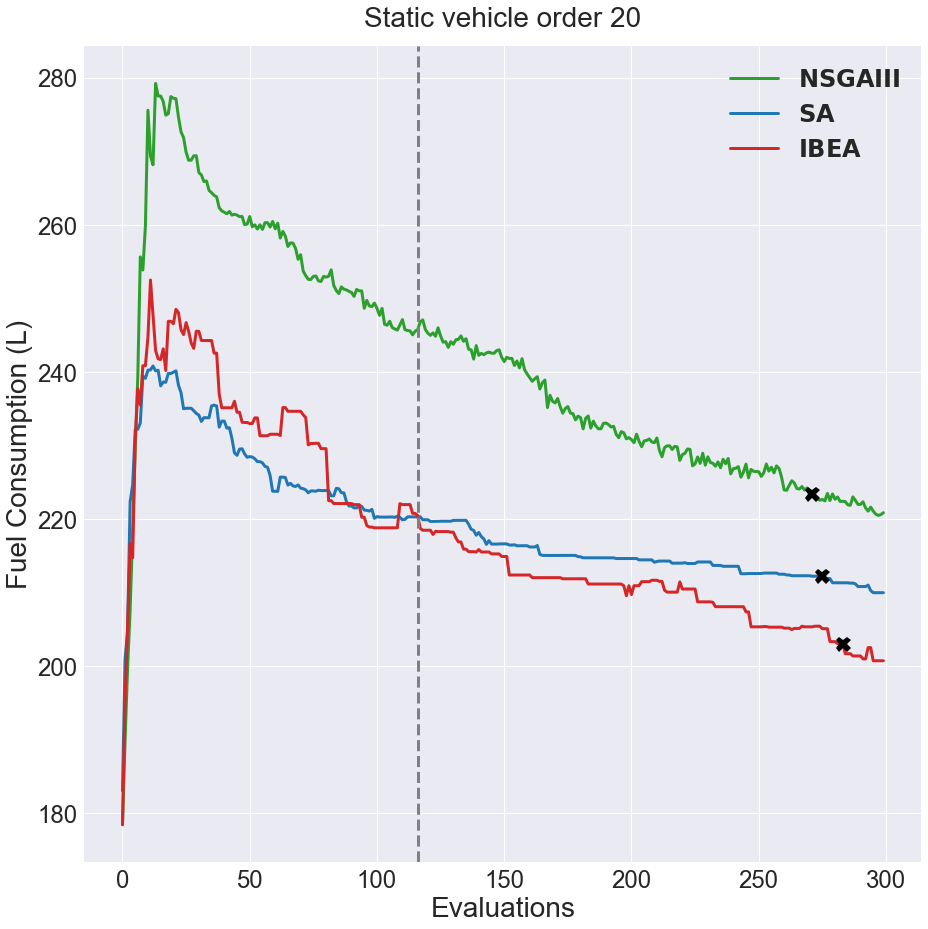

In [43]:
ax, fig = plot_curves_2(curves,["NSGAIII","SA","IBEA"])
plt.title("Static vehicle order 20")
plt.xlabel("Evaluations")
# plt.xticks(range(0,120,20),range(0,2400,400))
plt.ylabel("Fuel Consumption (L)")
#plt.ylim(top=700)
plt.legend()
plt.show()

In [25]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [69]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [120]:
%matplotlib inline
plt.ioff()
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 100
plots=[]
minx,maxx = np.min(points_coordinate[:,1]),np.max(points_coordinate[:,1])
miny,maxy = np.min(points_coordinate[:,0]),np.max(points_coordinate[:,0])

for index in tqdm(range(len(performance_observer_NSGAIII.path_history))[::10]):
    numerical_path = get_numerical_path(performance_observer_NSGAIII.path_history[index],vehicles)
    
    fig,_ = plot_routes(numerical_path,points_coordinate,dbf,station_ids = True, here_api=False, api_key=api)
    fig.set_size_inches(10,10)
    fig.axes[0].set_xlim(-2,1)#minx - abs(minx*0.05),maxx+maxx*0.05)
    fig.axes[0].set_ylim(50.5,52)#miny-miny*0.01,maxy + maxy*0.01)
    fig.axes[0].set_title("Fuel Consumption: {} (L)".format(round(performance_observer_NSGAIII.total_consumptions[index],2)),fontsize=20)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plots.append(image)
    plt.close(fig)
    
    


  0%|          | 0/100 [00:00<?, ?it/s]

In [121]:
import imageio 
imageio.mimsave('./test.gif', plots, fps=10)

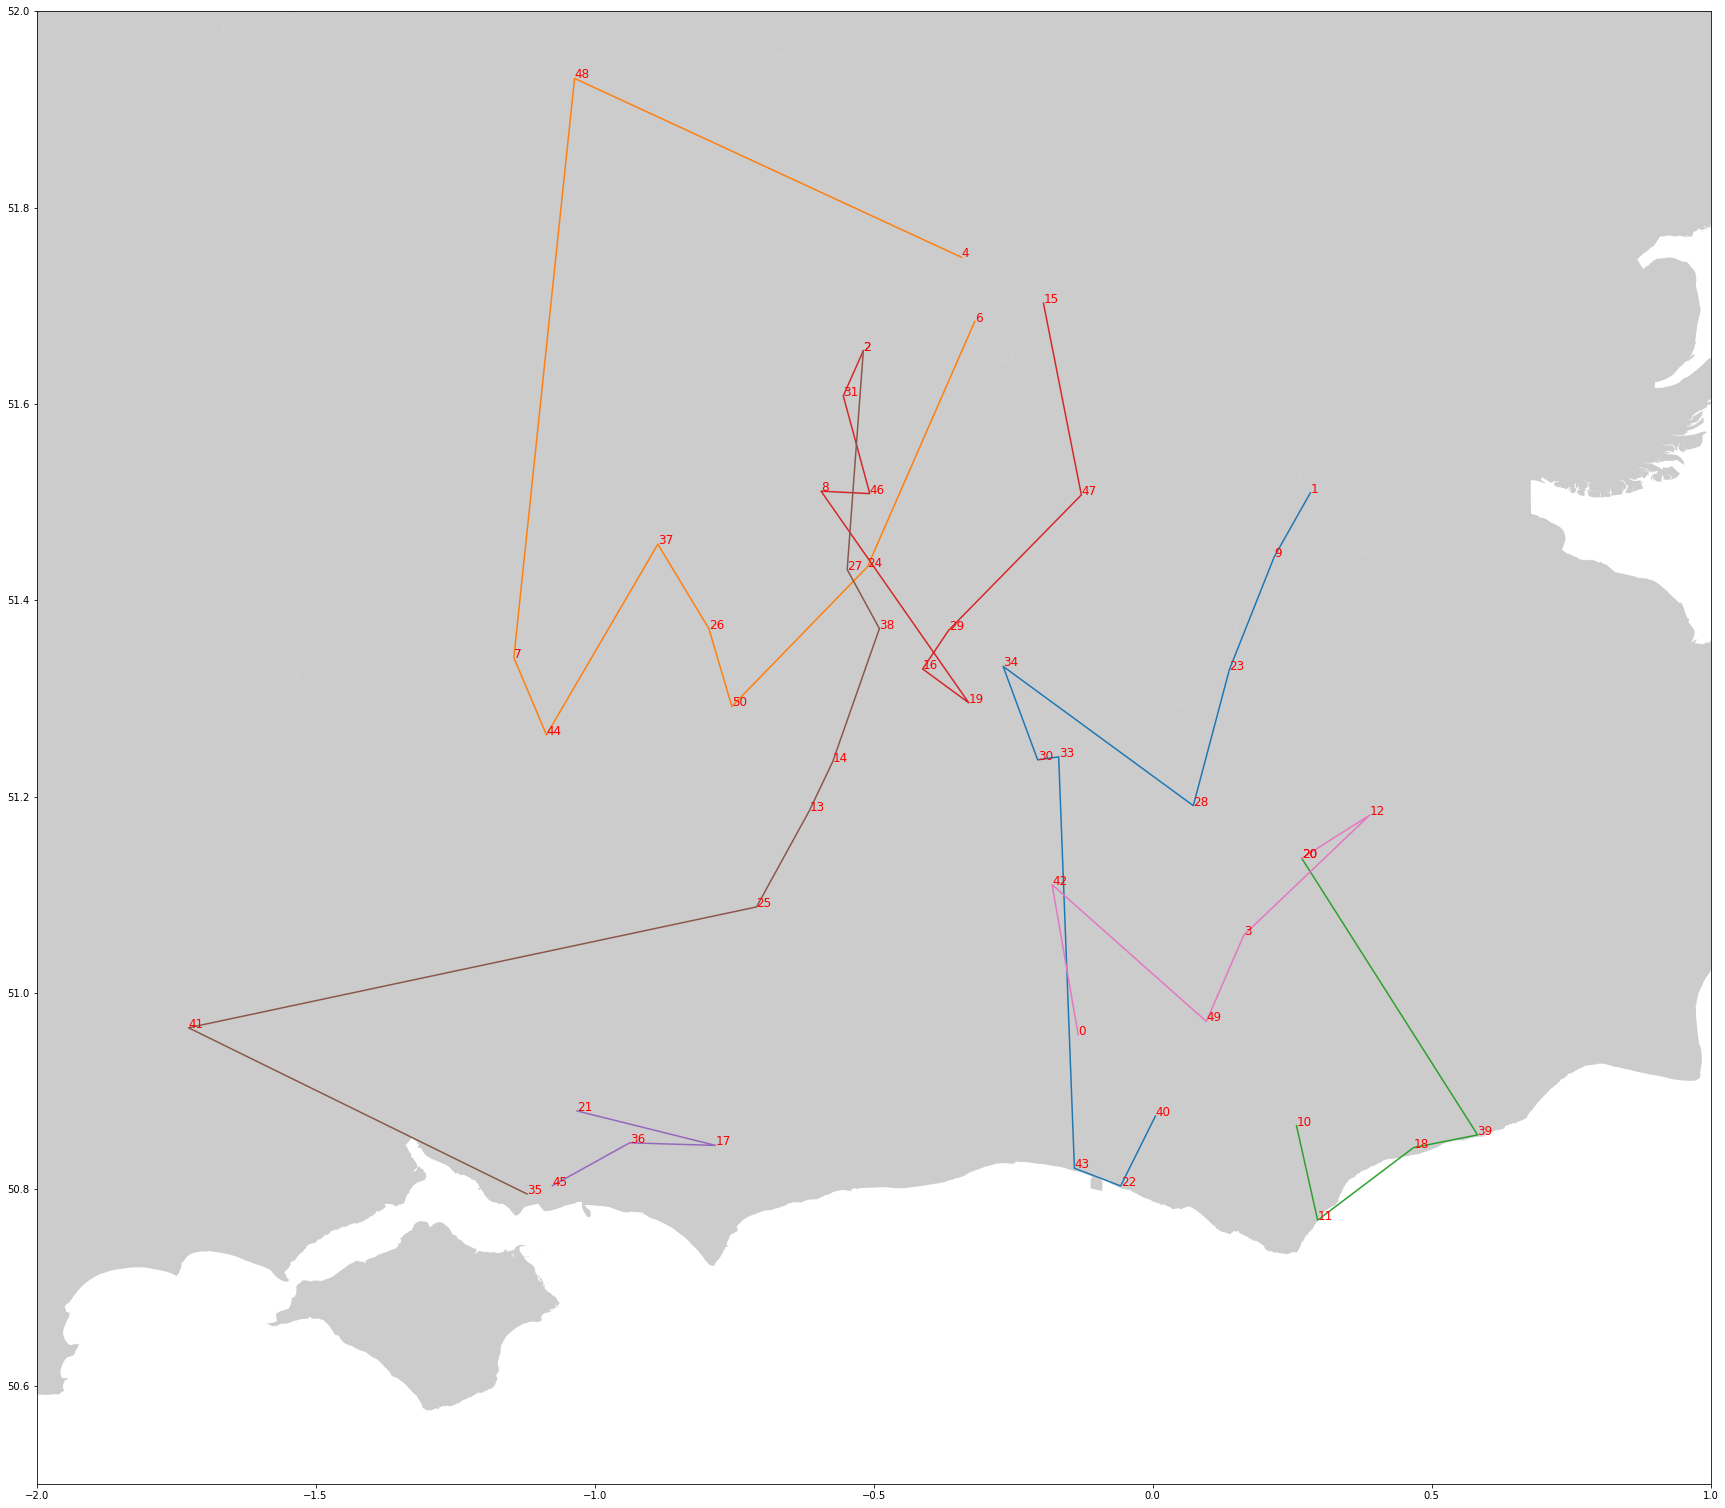

In [94]:
plot_routes(nsga3_numerical_path,points_coordinate,dbf,station_ids = True, here_api=False, api_key=api)
plt.xlim(-2,1)
plt.ylim(50.5,52)
plt.show()


(50.0, 53.0)

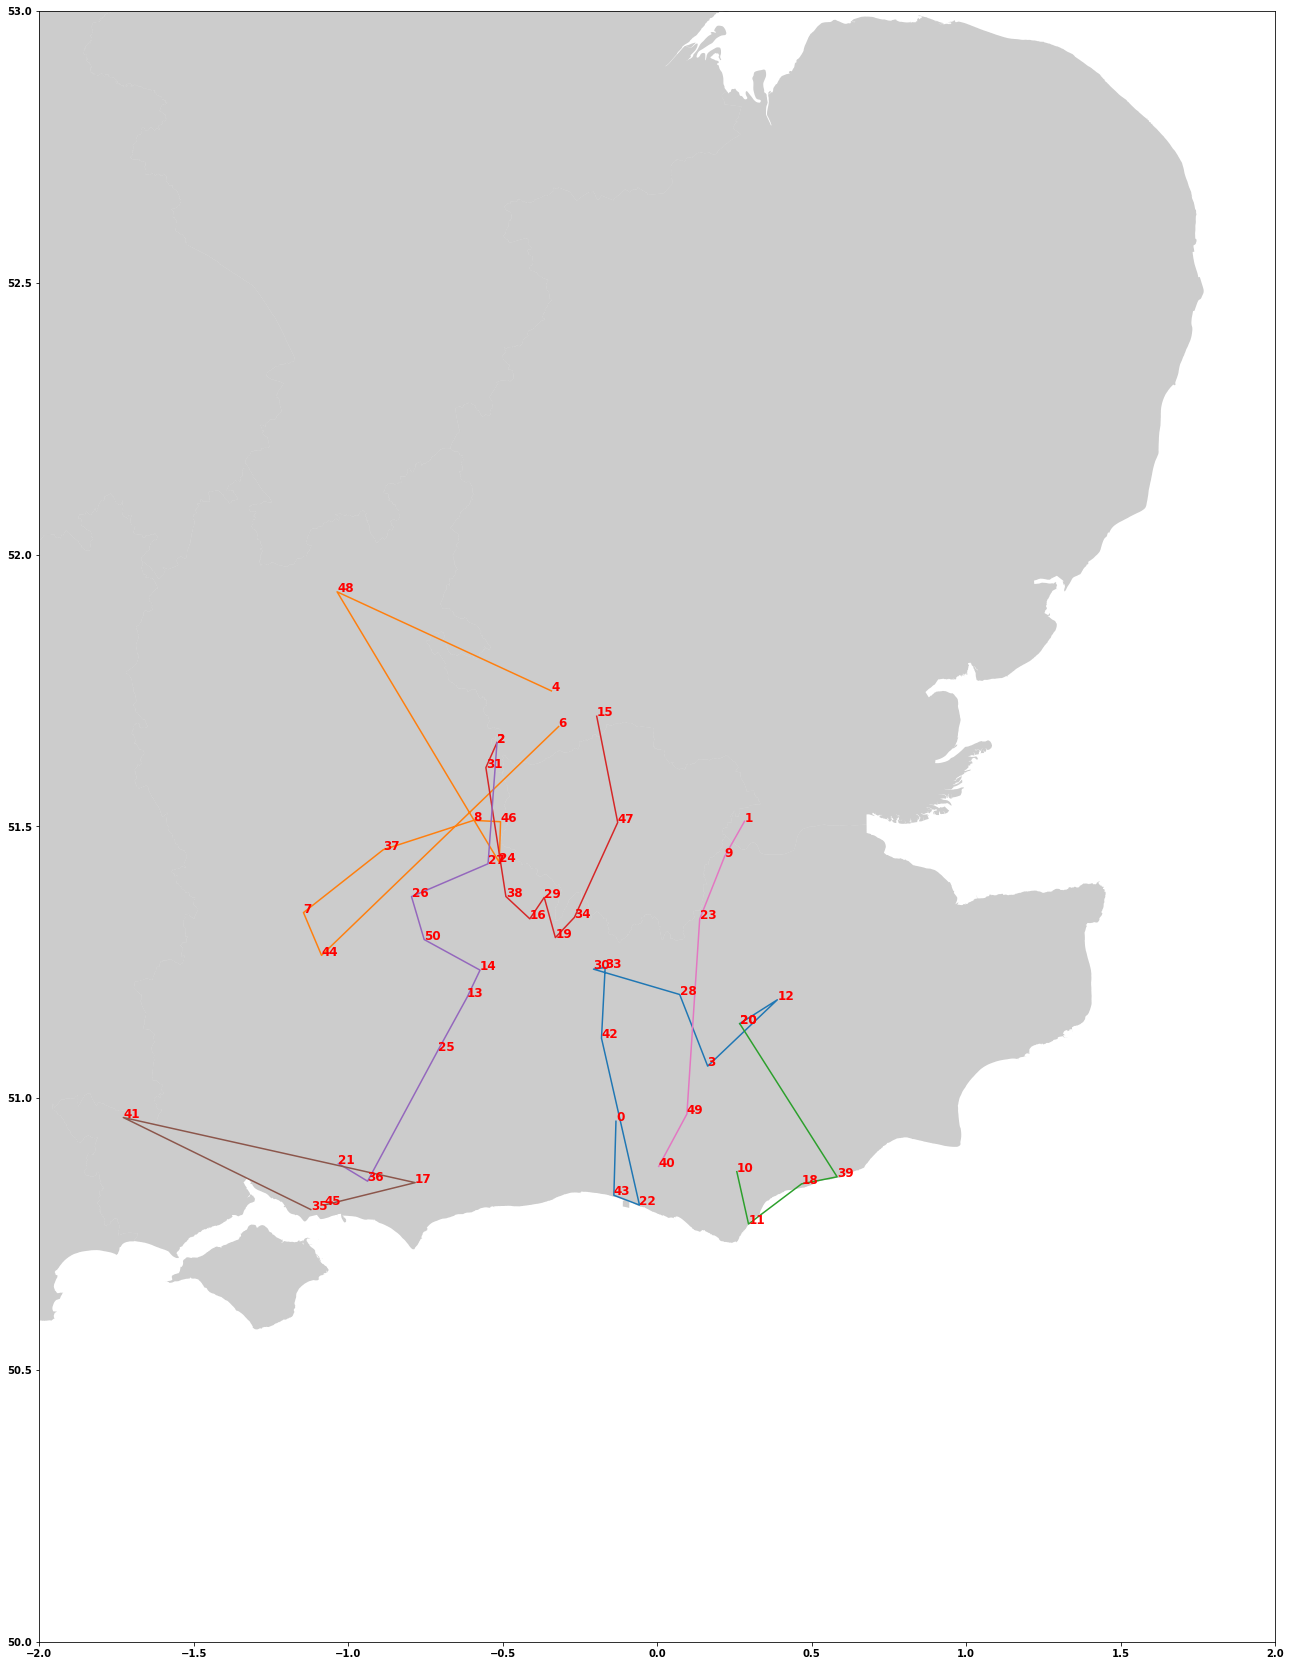

In [13]:
plot_routes(temppath2,points_coordinate,dbf,station_ids = True, here_api=False, api_key=api)
plt.xlim(-2,2)
plt.ylim(50,53)